In [1]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from concurrent.futures import ProcessPoolExecutor
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorly as tl

#Debugging import
import importlib
var = 'TensorDecisionTreeRegressorP' #the published version of code
package = importlib.import_module(var)
for name, value in package.__dict__.items():
    if not name.startswith("__"):
        globals()[name] = value

from TensorDecisionTreeRegressorP import *

import os
import nibabel as nib
import numpy as np
import matplotlib as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.measure import block_reduce

import os
import pandas as pd
import numpy as np
import nibabel as nib

# Load the CSV file containing PTID and target variable
csv_file = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/ADNIData.csv'
df = pd.read_csv(csv_file)

# Extract PTID and target values from the DataFrame
ptid_csv = df['PTID'].values
y_variable = df['ADAS11'].values

# Directory containing the image files
directory = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/3D-Images/bl'

# Initialize lists for storing matched images and corresponding y values
matched_images = []
matched_y_values = []

# Loop through the image files and match by PTID
for filename in os.listdir(directory):
    if filename.endswith('.nii.gz'):
        # Extract PTID from the filename (e.g., '002_S_0295.nii.gz' -> '002_S_0295')
        ptid_image = filename.split('.')[0]  # Keep the '002_S_0295' format with underscores
        
        # Find the index of this PTID in the CSV data
        if ptid_image in ptid_csv:
            index = np.where(ptid_csv == ptid_image)[0][0]  # Get the index of the matching PTID
            y_value = y_variable[index]  # Get the corresponding target value

            # Skip if the corresponding y_value is NaN
            if np.isnan(y_value):
                print(f"Skipping PTID '{ptid_image}' because y_value is NaN.")
                continue

            # Load the image
            file_path = os.path.join(directory, filename)
            img = nib.load(file_path)
            data = img.get_fdata()

            # Append the image data and the corresponding y_value to the lists
            matched_images.append(data)
            matched_y_values.append(y_value)
        else:
            print(f"PTID '{ptid_image}' not found in the CSV file.")

# Convert the matched images and y values into arrays
if matched_images:
    image_tensor = np.stack(matched_images, axis=0)
    y_variable = np.array(matched_y_values)
    print(f"Aligned image tensor shape: {image_tensor.shape}")
    print(f"Aligned y variable shape: {y_variable.shape}")
else:
    print("No images matched.")

Skipping PTID '013_S_0699' because y_value is NaN.
Aligned image tensor shape: (817, 48, 48, 48)
Aligned y variable shape: (817,)


In [2]:
# File path to the CSV file
csv_file = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/ADNIData.csv'
df = pd.read_csv(csv_file)
# Remove rows where ADAS11_bl is missing (NaN)
df_cleaned = df.dropna(subset=['ADAS11_bl'])

# Extract the 'ADAS11_bl' column as the y variable
y_variable = df_cleaned['ADAS11_bl'].values

# Split the dataframe based on the DX_bl column values
cn_group = df_cleaned[df_cleaned['DX_bl'] == 'CN']
ad_group = df_cleaned[df_cleaned['DX_bl'] == 'AD']
lmci_group = df_cleaned[df_cleaned['DX_bl'] == 'LMCI']

# Display the counts for each group after removing NA
print(f"CN group size: {cn_group.shape[0]}")
print(f"AD group size: {ad_group.shape[0]}")
print(f"LMCI group size: {lmci_group.shape[0]}")

# Directory containing the 3D images
directory = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/3D-Images/bl'

# Initialize dictionaries to hold the images and y values for each group
cn_images, ad_images, lmci_images = [], [], []
cn_y, ad_y, lmci_y = [], [], []

# Function to load the images based on PTID matching and append y values
def load_images_and_y(group, image_list, y_list):
    for _, row in group.iterrows():
        ptid = row['PTID']
        # Find the corresponding file based on PTID
        filename = f'{ptid}.nii.gz'
        file_path = os.path.join(directory, filename)
        
        if os.path.exists(file_path):
            # Load the NIfTI file
            img = nib.load(file_path)
            data = img.get_fdata()
            
            # Append the 3D image data and y value to the respective lists
            image_list.append(data)
            y_list.append(row['ADAS11_bl'])
        else:
            print(f"File {filename} not found.")

# Load images and y values for each group
load_images_and_y(cn_group, cn_images, cn_y)
load_images_and_y(ad_group, ad_images, ad_y)
load_images_and_y(lmci_group, lmci_images, lmci_y)

# Convert lists of 3D images and y values to NumPy arrays
if cn_images:
    cn_tensor = np.stack(cn_images, axis=0)
    cn_y = np.array(cn_y)
    print(f"CN 4D tensor shape: {cn_tensor.shape}")
    print(f"CN y shape: {cn_y.shape}")
else:
    print("No CN images loaded.")

if ad_images:
    ad_tensor = np.stack(ad_images, axis=0)
    ad_y = np.array(ad_y)
    print(f"AD 4D tensor shape: {ad_tensor.shape}")
    print(f"AD y shape: {ad_y.shape}")
else:
    print("No AD images loaded.")

if lmci_images:
    lmci_tensor = np.stack(lmci_images, axis=0)
    lmci_y = np.array(lmci_y)
    print(f"LMCI 4D tensor shape: {lmci_tensor.shape}")
    print(f"LMCI y shape: {lmci_y.shape}")
else:
    print("No LMCI images loaded.")

CN group size: 229
AD group size: 187
LMCI group size: 401
CN 4D tensor shape: (229, 48, 48, 48)
CN y shape: (229,)
AD 4D tensor shape: (187, 48, 48, 48)
AD y shape: (187,)
LMCI 4D tensor shape: (401, 48, 48, 48)
LMCI y shape: (401,)


In [3]:
def response_sim(X, signal, noise_mean=0, noise_std=0.001):
    y_sim = []
    for i in range(X.shape[0]):
        # Calculate the tensordot for each sample
        response_value = np.tensordot(X[i, :, :, :], signal, axes=([0, 1, 2], [0, 1, 2]))
        y_sim.append(response_value)
    
    # Convert list to array
    y_sim = np.array(y_sim)
    
    # Add normal noise to the response
    noise = np.random.normal(loc=noise_mean, scale=noise_std, size=y_sim.shape)
    y_sim += noise
    
    return y_sim

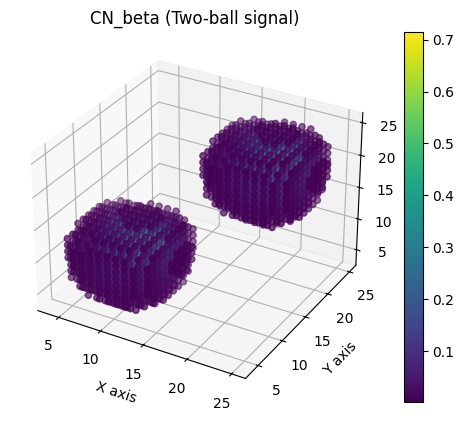

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# Assume these are dimensions of the MRI data
dim_x1, dim_x2, dim_x3 = 48, 48, 48

# Define function to create signal tensor
def create_signal_tensor(rank):
    if rank == 1:
        # One-ball signal (rank-1 decomposition)
        B1 = np.zeros((dim_x1, 1))
        B2 = np.zeros((dim_x2, 1))
        B3 = np.zeros((dim_x3, 1))
        for j in range(8):
            B1[5 + j, 0] = np.sin(j * np.pi / 14)
            B2[5 + j, 0] = np.sin(j * np.pi / 14)
            B3[5 + j, 0] = np.sin(j * np.pi / 14)
        return B1, B2, B3
    elif rank == 2:
        # Two-ball signal (rank-2 decomposition)
        B1 = np.zeros((dim_x1, 2))
        B2 = np.zeros((dim_x2, 2))
        B3 = np.zeros((dim_x3, 2))
        for j in range(8):
            B1[5 + j, 0] = np.sin(j * np.pi / 14)
            B2[5 + j, 0] = np.sin(j * np.pi / 14)
            B3[5 + j, 0] = np.sin(j * np.pi / 14)
            B1[15 + j, 1] = np.sin(j * np.pi / 14)
            B2[15 + j, 1] = np.sin(j * np.pi / 14)
            B3[15 + j, 1] = np.sin(j * np.pi / 14)
        return B1, B2, B3

# Function to pack the rank-1 tensor using np.tensordot
def pack_rank1_tensor(B1, B2, B3):
    return np.tensordot(np.tensordot(B1[:, 0], B2[:, 0], axes=0), B3[:, 0], axes=0)

# Function to pack the rank-2 tensor using np.tensordot
def pack_rank2_tensor(B1, B2, B3):
    tensor = np.zeros((dim_x1, dim_x2, dim_x3))
    for i in range(B1.shape[1]):  # Loop over both components (rank-2 tensor)
        tensor += np.tensordot(np.tensordot(B1[:, i], B2[:, i], axes=0), B3[:, i], axes=0)
    return tensor

# Function to plot 3D tensor using scatter plot
def plot_3d_tensor_scatter(tensor, title="3D Tensor Scatter Plot"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Prepare the grid matching the tensor dimensions
    x, y, z = np.meshgrid(np.arange(tensor.shape[0]),
                          np.arange(tensor.shape[1]),
                          np.arange(tensor.shape[2]),
                          indexing='ij')

    # Smooth the tensor values for visualization
    tensor_smoothed = gaussian_filter(tensor, sigma=1)

    # Flatten the arrays for scatter plot
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()
    values = tensor_smoothed.flatten()

    # Select points where tensor values are significant (above a threshold)
    isovalue = tensor_smoothed.mean()
    mask = values > isovalue
    x_plot = x_flat[mask]
    y_plot = y_flat[mask]
    z_plot = z_flat[mask]
    values_plot = values[mask]

    # Plot the scatter
    scatter = ax.scatter(x_plot, y_plot, z_plot, c=values_plot, cmap='viridis', marker='o')

    # Set labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title(title)

    # Add color bar to indicate values
    fig.colorbar(scatter, ax=ax)

    plt.show()

# Example usage:
# Generate and pack the rank-1 tensor (one-ball signal)
B1_rank1, B2_rank1, B3_rank1 = create_signal_tensor(rank=1)
tensor_rank1 = pack_rank1_tensor(B1_rank1, B2_rank1, B3_rank1)

# Generate and pack the rank-2 tensor (two-ball signal)
B1_rank2, B2_rank2, B3_rank2 = create_signal_tensor(rank=2)
tb_beta = pack_rank2_tensor(B1_rank2, B2_rank2, B3_rank2)

# Plot the rank-2 tensor using scatter plot (two-ball signal)
plot_3d_tensor_scatter(tb_beta, title="CN_beta (Two-ball signal)")

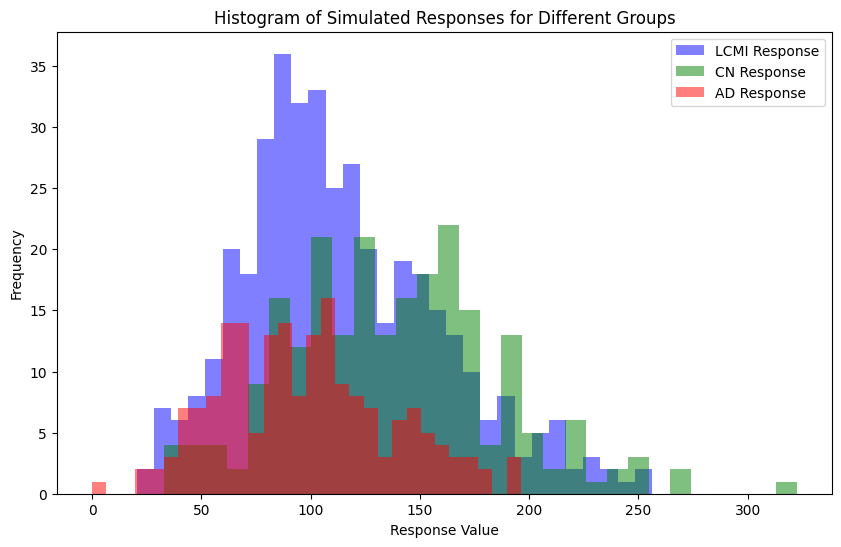

In [5]:


lmci_y_syn = response_sim(lmci_tensor, tb_beta)
cn_y_syn = response_sim(cn_tensor, tb_beta)
ad_y_syn = response_sim(ad_tensor, tb_beta)
y_variable_syn = np.concatenate([lmci_y_syn, cn_y_syn, ad_y_syn])
image_tensor_syn = np.concatenate([lmci_tensor, cn_tensor, ad_tensor])
plt.figure(figsize=(10, 6))

# Plot each histogram with transparency to compare overlaps
plt.hist(lmci_y_syn, bins=30, alpha=0.5, label='LCMI Response', color='blue')
plt.hist(cn_y_syn, bins=30, alpha=0.5, label='CN Response', color='green')
plt.hist(ad_y_syn, bins=30, alpha=0.5, label='AD Response', color='red')

# Add labels, title, and legend
plt.xlabel('Response Value')
plt.ylabel('Frequency')
plt.title('Histogram of Simulated Responses for Different Groups')
plt.legend()

# Display the plot
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(image_tensor_syn, y_variable_syn, test_size=0.3, random_state=41)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))

print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=2, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .1
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(571, 48, 48, 48) (571,)
mean train RSE:  6.329693201923571
CP train RSE:  4.1870581790265177e-07
Tucker train RSE:  2.5899449261696234e-07
mean test RSE:  6.923333532310938
CP test RSE:  0.8249068677315536
Tucker test RSE:  0.9127560407154381


In [15]:
coefs_tb_syn = model.get_fitted_coefs()

Plotting CP Coefficients for Tuple 1


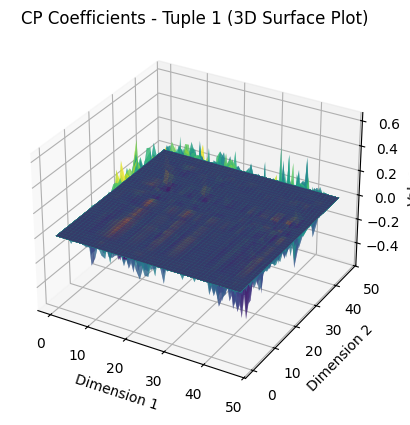

Plotting Tucker Coefficients for Tuple 1


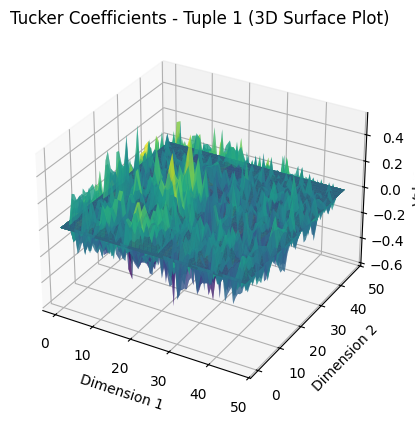

Plotting CP Coefficients for Tuple 2


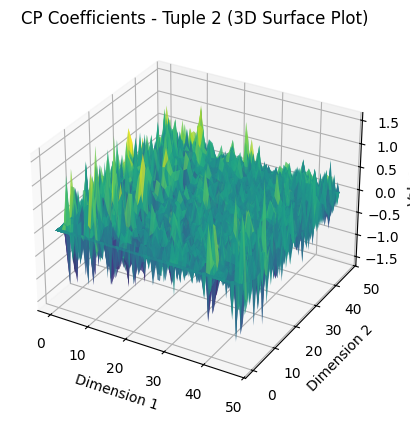

Plotting Tucker Coefficients for Tuple 2


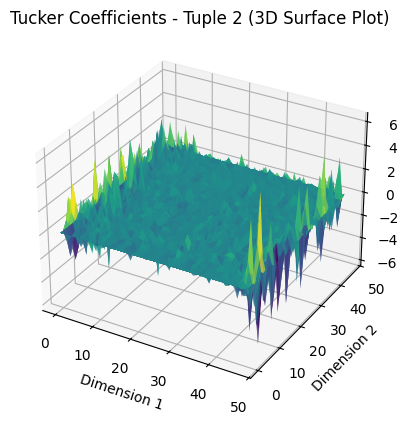

Plotting CP Coefficients for Tuple 3


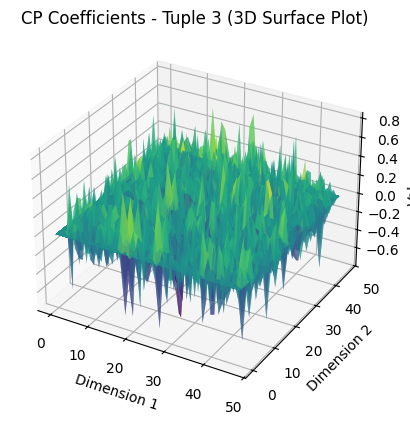

Plotting Tucker Coefficients for Tuple 3


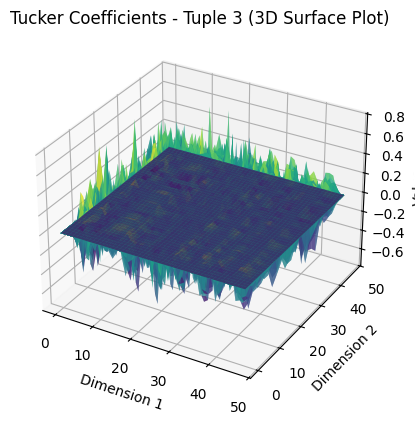

Plotting CP Coefficients for Tuple 4


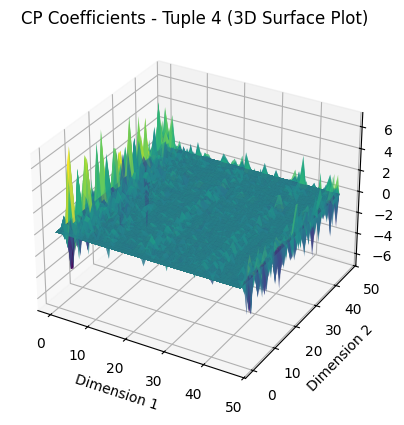

Plotting Tucker Coefficients for Tuple 4


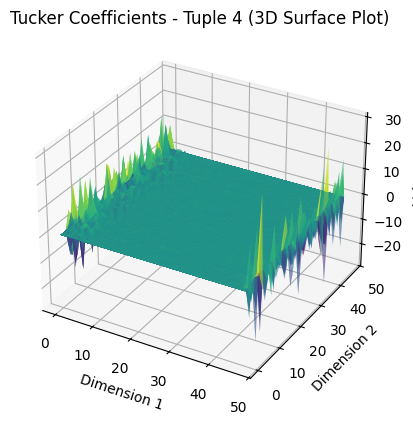

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot coefficient tensors from list of tuples
def plot_coefs_from_tuples(coefs):
    for tuple_idx, (cp_coefs, tucker_coefs) in enumerate(coefs):
        # Plot the first element in the tuple (cp_coefs)
        print(f"Plotting CP Coefficients for Tuple {tuple_idx + 1}")
        plot_tensor(cp_coefs, label=f"CP Coefficients - Tuple {tuple_idx + 1}")

        # Plot the second element in the tuple (tucker_coefs)
        print(f"Plotting Tucker Coefficients for Tuple {tuple_idx + 1}")
        plot_tensor(tucker_coefs, label=f"Tucker Coefficients - Tuple {tuple_idx + 1}")

# Helper function to plot a single tensor
def plot_tensor(tensor, label=""):
    tensor = np.array(tensor)  # Ensure it's a NumPy array

    if tensor.ndim == 2:
        # Plot 2D tensor as a heatmap
        plt.figure()
        plt.imshow(tensor, cmap='viridis', aspect='auto')
        plt.colorbar()
        plt.title(f'{label} (2D Heatmap)')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.show()

    elif tensor.ndim == 3:
        # Plot 3D tensor as a surface plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Create grid for the tensor's x, y dimensions
        x = np.arange(tensor.shape[0])
        y = np.arange(tensor.shape[1])
        X, Y = np.meshgrid(x, y)

        # Plot each layer of the third dimension as a separate surface plot
        for z_index in range(tensor.shape[2]):
            Z = tensor[:, :, z_index]  # Slice along the third dimension
            ax.plot_surface(X, Y, Z.T, cmap='viridis', alpha=0.6)

        ax.set_title(f'{label} (3D Surface Plot)')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Values')
        plt.show()

    elif tensor.ndim == 4:
        # For 4D tensors, display a subset of slices
        num_slices = min(tensor.shape[0], 5)  # Limit the number of slices to display
        fig, axes = plt.subplots(num_slices, tensor.shape[1], figsize=(15, 3 * num_slices))

        fig.suptitle(f'{label} (4D Slices)')
        for i in range(num_slices):
            for j in range(tensor.shape[1]):
                ax = axes[i, j] if num_slices > 1 else axes[j]
                ax.imshow(tensor[i, j], cmap='viridis', aspect='auto')
                ax.set_title(f'Slice {i + 1}, Layer {j + 1}')
                ax.axis('off')
        plt.show()

    else:
        print(f"Tensor has unsupported dimensions: {tensor.shape}")

# Run the function with your list of tuples
plot_coefs_from_tuples(coefs_tb_syn)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(image_tensor_syn, y_variable_syn, test_size=0.3, random_state=41)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))

print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=0, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .1
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(571, 48, 48, 48) (571,)
mean train RSE:  1.0
CP train RSE:  0.00039545036642580765
Tucker train RSE:  1.617198300572757e-05
mean test RSE:  1.0026604203302514
CP test RSE:  0.013481434247914172
Tucker test RSE:  0.00031266350406506294


Plotting CP Coefficients for Tuple 1


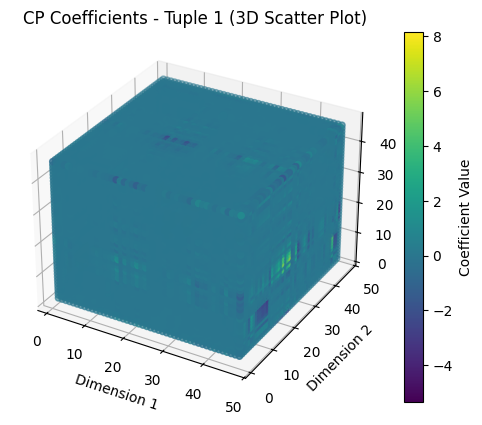

Plotting Tucker Coefficients for Tuple 1


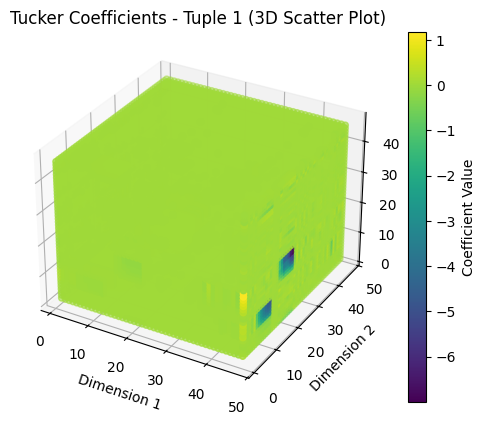

In [19]:
coefs_tb_syn = model.get_fitted_coefs()
plot_coefs_from_tuples(coefs_tb_syn)

In [7]:
model.print_tree()

  if X[:, 9 , 11 , 12 ] <=  2.3898514630289296
   if X[:, 22 , 16 , 21 ] <=  1.9435799379809564
     has  0  child nodes, and  115  samples.
   else: # if X[:, 22 , 16 , 21 ] >  1.9435799379809564
     has  0  child nodes, and  123  samples.
  else: # if X[:, 9 , 11 , 12 ] >  2.3898514630289296
   if X[:, 9 , 10 , 12 ] <=  3.0636909172699616
     has  0  child nodes, and  166  samples.
   else: # if X[:, 9 , 10 , 12 ] >  3.0636909172699616
     has  0  child nodes, and  167  samples.


In [8]:
x = model.root.get_leaves()

In [9]:
for idx, node in enumerate(x):
    print(f"Leaf Node {idx + 1}:")
    print(f"Number of Samples: {node.samples_X.shape[0]}")
    print(f"Predicted Value: {node.predicted_value}")  # Replace with the correct attribute if needed
    # Add more attributes as necessary
    print("-" * 30)

Leaf Node 1:
Number of Samples: 115
Predicted Value: 66.34097533967505
------------------------------
Leaf Node 2:
Number of Samples: 123
Predicted Value: 107.41841999108954
------------------------------
Leaf Node 3:
Number of Samples: 166
Predicted Value: 115.39438927919953
------------------------------
Leaf Node 4:
Number of Samples: 167
Predicted Value: 162.09566114562037
------------------------------


In [16]:
import importlib
import BayesTensorRegressor
importlib.reload(BayesTensorRegressor)
from BayesTensorRegressor import TensorRegression
from skimage.measure import block_reduce
from sklearn.model_selection import train_test_split
import numpy as np

# Initialize the tensor regression model
B_model = TensorRegression(a_lam=None, b_lam=None, phi_alpha=None)

# Split the dataset
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(image_tensor, y_variable, np.zeros((817, 1)), test_size=0.2, random_state=42)

# Define parameters
X_coarsen_shape = (1, 4, 4, 4)
X_coarsen_func = np.mean
nsweep = 4000
rank = 3
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1

# Get leaf node assignments for training and testing data
train_leaf_assignments = model.apply(X_train)
test_leaf_assignments = model.apply(X_test)

# Retrieve unique leaf nodes
unique_train_nodes = np.unique(train_leaf_assignments)
unique_test_nodes = np.unique(test_leaf_assignments)

# Initialize lists to collect errors for each leaf node
training_errors = []
testing_errors = []

# Loop over each unique leaf node
for node_id in unique_train_nodes:
    print(f"Processing leaf node {node_id}")
    
    # Filter the samples assigned to the current node in training and testing data
    X_train_node = X_train[train_leaf_assignments == node_id]
    y_train_node = y_train[train_leaf_assignments == node_id]
    X_test_node = X_test[test_leaf_assignments == node_id]
    y_test_node = y_test[test_leaf_assignments == node_id]
    z_train = np.zeros((X_train_node.shape[0], 1))

    # Coarsen training and testing data
    X_train_c = block_reduce(X_train_node, block_size=X_coarsen_shape, func=X_coarsen_func)
    X_test_c = block_reduce(X_test_node, block_size=X_coarsen_shape, func=X_coarsen_func)
    X_train_c += np.random.randn(*X_train_c.shape) * 1e-3  # Add slight noise to training data
    
    # Run tensor regression on the coarsened training data
    out = B_model.tensor_reg(z_train=z_train, x_train=X_train_c, y_train=y_train_node,
                             nsweep=nsweep, rank=rank, burn=burn, nskip=nskip, scale=True)
    
    # Compute Beta_mcmc and Beta_est
    Beta_mcmc = B_model.getBeta_mcmc(out['beta_store'])
    p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]
    Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)
    
    # Calculate training error (relative MSE)
    err_train = 0
    for j in range(X_train_c.shape[0]):
        pred_train = np.tensordot(X_train_c[j], Beta_est, axes=((0, 1, 2), (0, 1, 2)))
        err_train += (pred_train - y_train_node[j])**2
    mse_train = err_train / X_train_c.shape[0]
    rmse_train = mse_train / np.var(y_train_node)
    training_errors.append(rmse_train)
    print(f"Training RMSE for node {node_id}: {rmse_train}")

    # Calculate testing error (relative MSE)
    err_test = 0
    for j in range(X_test_c.shape[0]):
        pred_test = np.tensordot(X_test_c[j], Beta_est, axes=((0, 1, 2), (0, 1, 2)))
        err_test += (pred_test - y_test_node[j])**2
    mse_test = err_test / X_test_c.shape[0]
    rmse_test = mse_test / np.var(y_test_node)
    testing_errors.append(rmse_test)
    print(f"Testing RMSE for node {node_id}: {rmse_test}")

# Output the collected training and testing errors for each node
print("Training RMSE for each node:", training_errors)
print("Testing RMSE for each node:", testing_errors)



Processing leaf node 3
Time out: 414.7744891643524
Training RMSE for node 3: 3.0974308461615263
Testing RMSE for node 3: 5.120502804248334
Processing leaf node 4
Time out: 462.2876238822937
Training RMSE for node 4: 1.609876242551068
Testing RMSE for node 4: 2.969518288391818
Processing leaf node 7
Time out: 566.3848288059235
Training RMSE for node 7: 0.8756410395556451
Testing RMSE for node 7: 1.56407451948236
Processing leaf node 8
Time out: 616.2635080814362
Training RMSE for node 8: 2.217019385483376
Testing RMSE for node 8: 3.9528116299259937
Training RMSE for each node: [np.float64(3.0974308461615263), np.float64(1.609876242551068), np.float64(0.8756410395556451), np.float64(2.217019385483376)]
Testing RMSE for each node: [np.float64(5.120502804248334), np.float64(2.969518288391818), np.float64(1.56407451948236), np.float64(3.9528116299259937)]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(image_tensor_syn, y_variable_syn, test_size=0.3, random_state=41)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))

print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=2, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .1
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))






# Initialize the tensor regression model
B_model = TensorRegression(a_lam=None, b_lam=None, phi_alpha=None)



# Define parameters
X_coarsen_shape = (1, 4, 4, 4)
X_coarsen_func = np.mean
nsweep = 4000
rank = 3
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1

# Get leaf node assignments for training and testing data
train_leaf_assignments = model.apply(X_train)
test_leaf_assignments = model.apply(X_test)

# Retrieve unique leaf nodes
unique_train_nodes = np.unique(train_leaf_assignments)
unique_test_nodes = np.unique(test_leaf_assignments)

# Initialize lists to collect errors for each leaf node
training_errors = []
testing_errors = []

# Loop over each unique leaf node
for node_id in unique_train_nodes:
    print(f"Processing leaf node {node_id}")
    
    # Filter the samples assigned to the current node in training and testing data
    X_train_node = X_train[train_leaf_assignments == node_id]
    y_train_node = y_train[train_leaf_assignments == node_id]
    X_test_node = X_test[test_leaf_assignments == node_id]
    y_test_node = y_test[test_leaf_assignments == node_id]
    z_train = np.zeros((X_train_node.shape[0], 1))

    # Coarsen training and testing data
    X_train_c = block_reduce(X_train_node, block_size=X_coarsen_shape, func=X_coarsen_func)
    X_test_c = block_reduce(X_test_node, block_size=X_coarsen_shape, func=X_coarsen_func)
    X_train_c += np.random.randn(*X_train_c.shape) * 1e-3  # Add slight noise to training data
    
    # Run tensor regression on the coarsened training data
    out = B_model.tensor_reg(z_train=z_train, x_train=X_train_c, y_train=y_train_node,
                             nsweep=nsweep, rank=rank, burn=burn, nskip=nskip, scale=True)
    
    # Compute Beta_mcmc and Beta_est
    Beta_mcmc = B_model.getBeta_mcmc(out['beta_store'])
    p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]
    Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)
    
    # Calculate training error (relative MSE)
    err_train = 0
    for j in range(X_train_c.shape[0]):
        pred_train = np.tensordot(X_train_c[j], Beta_est, axes=((0, 1, 2), (0, 1, 2)))
        err_train += (pred_train - y_train_node[j])**2
    mse_train = err_train / X_train_c.shape[0]
    rmse_train = mse_train / np.var(y_train_node)
    training_errors.append(rmse_train)
    print(f"Training RMSE for node {node_id}: {rmse_train}")

    # Calculate testing error (relative MSE)
    err_test = 0
    for j in range(X_test_c.shape[0]):
        pred_test = np.tensordot(X_test_c[j], Beta_est, axes=((0, 1, 2), (0, 1, 2)))
        err_test += (pred_test - y_test_node[j])**2
    mse_test = err_test / X_test_c.shape[0]
    rmse_test = mse_test / np.var(y_test_node)
    testing_errors.append(rmse_test)
    print(f"Testing RMSE for node {node_id}: {rmse_test}")

# Output the collected training and testing errors for each node
print("Training RMSE for each node:", training_errors)
print("Testing RMSE for each node:", testing_errors)


(571, 48, 48, 48) (571,)
mean train RSE:  6.329093070656373
CP train RSE:  3.160725855745855e-07
Tucker train RSE:  1.4726140252337892e-07
mean test RSE:  6.938090263525454
CP test RSE:  1.2670818815939384
Tucker test RSE:  0.8169132867282468
Processing leaf node 3
Time out: 810.2620651721954
Training RMSE for node 3: 0.5361901809601021
Testing RMSE for node 3: 0.48995948745631196
Processing leaf node 4
Time out: 426.5966157913208
Training RMSE for node 4: 0.2086982015469336
Testing RMSE for node 4: 0.4311811659272966
Processing leaf node 7
Time out: 431.1765880584717
Training RMSE for node 7: 0.06596780558795469
Testing RMSE for node 7: 0.15926485055417539
Processing leaf node 8
Time out: 499.80609703063965
Training RMSE for node 8: 0.39815194463660086
Testing RMSE for node 8: 0.7242459986075757
Training RMSE for each node: [np.float64(0.5361901809601021), np.float64(0.2086982015469336), np.float64(0.06596780558795469), np.float64(0.39815194463660086)]
Testing RMSE for each node: [np.

In [20]:
import importlib
import BayesTensorRegressor
importlib.reload(BayesTensorRegressor)
from BayesTensorRegressor import TensorRegression
from skimage.measure import block_reduce
from sklearn.model_selection import train_test_split
import numpy as np

# Define the response simulation function
def response_sim(X, signal, noise_mean=0, noise_std=0.001):
    y_sim = []
    for i in range(X.shape[0]):
        response_value = np.tensordot(X[i, :, :, :], signal, axes=([0, 1, 2], [0, 1, 2]))
        y_sim.append(response_value)
    y_sim = np.array(y_sim)
    noise = np.random.normal(loc=noise_mean, scale=noise_std, size=y_sim.shape)
    y_sim += noise
    return y_sim

# Load constants
const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))

# Initialize parameters
X_coarsen_shape = (1, 4, 4, 4)
X_coarsen_func = np.mean
nsweep = 4000
rank = 3
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1

# Given fixed data
# Assuming lmci_tensor, cn_tensor, ad_tensor, and tb_beta are predefined

# Initialize a dictionary to store RMSE values per node across random states
train_rmse_per_node = {}
test_rmse_per_node = {}

# Initialize lists to collect RSE for mean, CP, and Tucker regression methods
train_rse_mean, test_rse_mean = [], []
train_rse_cp, test_rse_cp = [], []
train_rse_tucker, test_rse_tucker = [], []

# Loop over multiple random states
for random_state in range(42, 53):
    print(f"Random state: {random_state}")

    # Generate synthetic response variable for each loop
    lmci_y_syn = response_sim(lmci_tensor, tb_beta)
    cn_y_syn = response_sim(cn_tensor, tb_beta)
    ad_y_syn = response_sim(ad_tensor, tb_beta)
    
    y_variable_syn = np.concatenate([lmci_y_syn, cn_y_syn, ad_y_syn])
    image_tensor_syn = np.concatenate([lmci_tensor, cn_tensor, ad_tensor])

    # Split the dataset for the current random state
    X_train, X_test, y_train, y_test = train_test_split(image_tensor_syn, y_variable_syn, test_size=0.3, random_state=random_state)
    
    # Initialize the tree model
    model = TensorDecisionTreeRegressor(max_depth=2, min_samples_split=12, split_method='variance_LS', 
                                        split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
    model.sample_rate = .1
    model.fit(X_train, y_train)
    # Evaluate overall model performance using mean, CP, and Tucker methods
    predictions = model.predict(X_train, regression_method='mean')
    train_rse_mean.append(np.mean((predictions - y_train)**2) / np.var(y_train))
    predictions = model.predict(X_train, regression_method='cp')
    train_rse_cp.append(np.mean((predictions - y_train)**2) / np.var(y_train))
    predictions = model.predict(X_train, regression_method='tucker')
    train_rse_tucker.append(np.mean((predictions - y_train)**2) / np.var(y_train))
    
    predictions = model.predict(X_test, regression_method='mean')
    test_rse_mean.append(np.mean((predictions - y_test)**2) / np.var(y_test))
    predictions = model.predict(X_test, regression_method='cp')
    test_rse_cp.append(np.mean((predictions - y_test)**2) / np.var(y_test))
    predictions = model.predict(X_test, regression_method='tucker')
    test_rse_tucker.append(np.mean((predictions - y_test)**2) / np.var(y_test))
    # Get leaf node assignments for training and testing data
    train_leaf_assignments = model.apply(X_train)
    test_leaf_assignments = model.apply(X_test)
    
    # Retrieve unique leaf nodes
    unique_train_nodes = np.unique(train_leaf_assignments)
    
    # Loop over each unique leaf node
    for node_id in unique_train_nodes:
        
        # Filter the samples assigned to the current node in training and testing data
        X_train_node = X_train[train_leaf_assignments == node_id]
        y_train_node = y_train[train_leaf_assignments == node_id]
        X_test_node = X_test[test_leaf_assignments == node_id]
        y_test_node = y_test[test_leaf_assignments == node_id]
        z_train = np.zeros((X_train_node.shape[0], 1))

        # Coarsen training and testing data
        X_train_c = block_reduce(X_train_node, block_size=X_coarsen_shape, func=X_coarsen_func)
        X_test_c = block_reduce(X_test_node, block_size=X_coarsen_shape, func=X_coarsen_func)
        X_train_c += np.random.randn(*X_train_c.shape) * 1e-3  # Add slight noise to training data
        
        # Run tensor regression on the coarsened training data
        print(f"Running Bayes tensor_reg for node {node_id}")
        out = B_model.tensor_reg(z_train=z_train, x_train=X_train_c, y_train=y_train_node,
                                 nsweep=nsweep, rank=rank, burn=burn, nskip=nskip, scale=True)
        
        # Compute Beta_mcmc and Beta_est
        Beta_mcmc = B_model.getBeta_mcmc(out['beta_store'])
        p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]
        Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)
        
        # Calculate training error (relative MSE)
        err_train = 0
        for j in range(X_train_c.shape[0]):
            pred_train = np.tensordot(X_train_c[j], Beta_est, axes=((0, 1, 2), (0, 1, 2)))
            err_train += (pred_train - y_train_node[j])**2
        mse_train = err_train / X_train_c.shape[0]
        rmse_train = mse_train / np.var(y_train_node)
        
        # Store the training RMSE per node
        if node_id not in train_rmse_per_node:
            train_rmse_per_node[node_id] = []
        train_rmse_per_node[node_id].append(rmse_train)
        print(f"Training RMSE for node {node_id}: {rmse_train}")

        # Calculate testing error (relative MSE)
        err_test = 0
        for j in range(X_test_c.shape[0]):
            pred_test = np.tensordot(X_test_c[j], Beta_est, axes=((0, 1, 2), (0, 1, 2)))
            err_test += (pred_test - y_test_node[j])**2
        mse_test = err_test / X_test_c.shape[0]
        rmse_test = mse_test / np.var(y_test_node)
        
        # Store the testing RMSE per node
        if node_id not in test_rmse_per_node:
            test_rmse_per_node[node_id] = []
        test_rmse_per_node[node_id].append(rmse_test)
        print(f"Testing RMSE for node {node_id}: {rmse_test}")
    


# Calculate mean and standard deviation of RMSE per node across all random states
train_rmse_stats_per_node = {node_id: (np.mean(rmse_list), np.std(rmse_list)) for node_id, rmse_list in train_rmse_per_node.items()}
test_rmse_stats_per_node = {node_id: (np.mean(rmse_list), np.std(rmse_list)) for node_id, rmse_list in test_rmse_per_node.items()}

# Calculate overall RSE mean and std for mean, CP, and Tucker methods
train_rse_mean_stats = (np.mean(train_rse_mean), np.std(train_rse_mean))
test_rse_mean_stats = (np.mean(test_rse_mean), np.std(test_rse_mean))
train_rse_cp_stats = (np.mean(train_rse_cp), np.std(train_rse_cp))
test_rse_cp_stats = (np.mean(test_rse_cp), np.std(test_rse_cp))
train_rse_tucker_stats = (np.mean(train_rse_tucker), np.std(train_rse_tucker))
test_rse_tucker_stats = (np.mean(test_rse_tucker), np.std(test_rse_tucker))

# Output the results
print("Training RMSE stats per node (Mean, Std):", train_rmse_stats_per_node)
print("Testing RMSE stats per node (Mean, Std):", test_rmse_stats_per_node)
print("Overall RSE stats:")
print(f"Mean method - Train RSE (Mean, Std): {train_rse_mean_stats}, Test RSE (Mean, Std): {test_rse_mean_stats}")
print(f"CP method - Train RSE (Mean, Std): {train_rse_cp_stats}, Test RSE (Mean, Std): {test_rse_cp_stats}")
print(f"Tucker method - Train RSE (Mean, Std): {train_rse_tucker_stats}, Test RSE (Mean, Std): {test_rse_tucker_stats}")


Random state: 42
Running Bayes tensor_reg for node 3
Time out: 431.16188788414
Training RMSE for node 3: 0.10566195852392535
Testing RMSE for node 3: 0.29935823136829376
Running Bayes tensor_reg for node 4
Time out: 410.90039801597595
Training RMSE for node 4: 0.08974465187931922
Testing RMSE for node 4: 0.4183229712093499
Running Bayes tensor_reg for node 7
Time out: 458.26440501213074
Training RMSE for node 7: 0.49013589977590466
Testing RMSE for node 7: 0.8249697048459844
Running Bayes tensor_reg for node 8
Time out: 453.0877139568329
Training RMSE for node 8: 0.10262437021626865
Testing RMSE for node 8: 0.24030853141773797
Random state: 43
Running Bayes tensor_reg for node 3
Time out: 1446.9036791324615
Training RMSE for node 3: 0.7629650544002452
Testing RMSE for node 3: 1.144442010748722
Running Bayes tensor_reg for node 4
Time out: 926.513671875
Training RMSE for node 4: 0.08519650764047956
Testing RMSE for node 4: 0.1938765011403305
Running Bayes tensor_reg for node 7
Time out:

In [21]:
test_rse_cp_stats

(np.float64(1.0259607576856529), np.float64(0.1787293363978548))

In [ ]:
test_rse_cp_stats